In [0]:
%tensorflow_version 2.x

In [2]:
# Type of GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [3]:
# Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 38.0 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import random
RS = 27
random.seed(RS)
np.random.seed(RS)

In [6]:
# Read training data. 
# Inspections of restaurants
scores_known = pd.read_csv('./facility_scores_known.csv')
scores_known.head()

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category,Neighborhoods (old),Police Districts,Supervisor Districts,Fire Prevention Districts,Zip Codes,Analysis Neighborhoods
0,69618,Fancy Wheatfield Bakery,1362 Stockton St,San Francisco,CA,94133,NaN,NaN,NaN,NaN,69618_20190304,3/4/19 0:00,NaN,Complaint,69618_20190304_103130,Inadequate sewage or wastewater disposal,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN
1,97975,BREADBELLY,1408 Clement St,San Francisco,CA,94118,NaN,NaN,NaN,1.415724e+10,97975_20190725,7/25/19 0:00,96.0,Routine - Unscheduled,97975_20190725_103124,Inadequately cleaned or sanitized food contact...,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN
2,69487,Hakkasan San Francisco,1 Kearny St,San Francisco,CA,94108,NaN,NaN,NaN,NaN,69487_20180418,4/18/18 0:00,88.0,Routine - Unscheduled,69487_20180418_103119,Inadequate and inaccessible handwashing facili...,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN
3,91044,Chopsticks Restaurant,4615 Mission St,San Francisco,CA,94112,NaN,NaN,NaN,NaN,91044_20170818,8/18/17 0:00,NaN,Non-inspection site visit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85987,Tselogs,552 Jones St,San Francisco,CA,94102,NaN,NaN,NaN,NaN,85987_20180412,4/12/18 0:00,94.0,Routine - Unscheduled,85987_20180412_103132,Improper thawing methods,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Drop rows that have no inspection score. 
score_cleaned = scores_known.dropna(subset=['inspection_score'])
# Narrow down the columns. 
# A. score_data = score_cleaned[['violation_description', 'risk_category', 'inspection_score']]
# B. score_data = score_cleaned[['violation_description', 'risk_category', 'inspection_score', 'business_latitude', 'business_longitude']]
# C score_data = score_cleaned[['violation_description', 'risk_category', 'inspection_score', 'business_postal_code', 'business_latitude', 'business_longitude']]
# E. 
# score_data = score_cleaned[['violation_description', 'risk_category', 
#                                'business_postal_code', 'business_latitude', 'business_longitude', 
#                                'inspection_score', 
#                                'Neighborhoods (old)', 'Police Districts', 'Supervisor Districts', 
#                                'Fire Prevention Districts', 'Zip Codes', 'Analysis Neighborhoods']]

# H.
score_data = score_cleaned[['business_name', 'business_address', 'violation_description', 'risk_category', 
                               'business_postal_code', 'business_latitude', 'business_longitude', 
                               'inspection_score', 
                               'Neighborhoods (old)', 'Police Districts', 'Supervisor Districts', 
                               'Fire Prevention Districts', 'Zip Codes', 'Analysis Neighborhoods']]

score_data.head()

,business_name,business_address,violation_description,risk_category,business_postal_code,business_latitude,business_longitude,inspection_score,Neighborhoods (old),Police Districts,Supervisor Districts,Fire Prevention Districts,Zip Codes,Analysis Neighborhoods
1,BREADBELLY,1408 Clement St,Inadequately cleaned or sanitized food contact...,Moderate Risk,94118,NaN,NaN,96.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Hakkasan San Francisco,1 Kearny St,Inadequate and inaccessible handwashing facili...,Moderate Risk,94108,NaN,NaN,88.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Tselogs,552 Jones St,Improper thawing methods,Moderate Risk,94102,NaN,NaN,94.0,NaN,NaN,NaN,NaN,NaN,NaN
7,"The Estate Kitchen, LLC",799 Bryant St,Improper food storage,Low Risk,94107,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN
8,Beloved Cafe,3338 24th St,Low risk vermin infestation,Low Risk,94110,NaN,NaN,96.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Define the ordinal scale of 'risk_category' column. 
score_data['risk_category'] = score_data['risk_category'].fillna('Good')
risk_mapping = {'High Risk': 0, 'Moderate Risk': 1, 'Low Risk': 2, 'Good': 3}
score_data['risk_category'] = score_data['risk_category'].map(risk_mapping)
score_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,business_name,business_address,violation_description,risk_category,business_postal_code,business_latitude,business_longitude,inspection_score,Neighborhoods (old),Police Districts,Supervisor Districts,Fire Prevention Districts,Zip Codes,Analysis Neighborhoods
1,BREADBELLY,1408 Clement St,Inadequately cleaned or sanitized food contact...,1,94118,NaN,NaN,96.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Hakkasan San Francisco,1 Kearny St,Inadequate and inaccessible handwashing facili...,1,94108,NaN,NaN,88.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Tselogs,552 Jones St,Improper thawing methods,1,94102,NaN,NaN,94.0,NaN,NaN,NaN,NaN,NaN,NaN
7,"The Estate Kitchen, LLC",799 Bryant St,Improper food storage,2,94107,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN
8,Beloved Cafe,3338 24th St,Low risk vermin infestation,2,94110,NaN,NaN,96.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
score_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21463 entries, 1 to 30615
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   business_name              21463 non-null  object 
 1   business_address           21463 non-null  object 
 2   violation_description      20311 non-null  object 
 3   risk_category              21463 non-null  int64  
 4   business_postal_code       20925 non-null  object 
 5   business_latitude          7591 non-null   float64
 6   business_longitude         7591 non-null   float64
 7   inspection_score           21463 non-null  float64
 8   Neighborhoods (old)        7590 non-null   float64
 9   Police Districts           7590 non-null   float64
 10  Supervisor Districts       7590 non-null   float64
 11  Fire Prevention Districts  7584 non-null   float64
 12  Zip Codes                  7590 non-null   float64
 13  Analysis Neighborhoods     7590 non-null   flo

In [10]:
# One hot encoding for 'violation_description' column
df_dummy = pd.get_dummies(score_data['violation_description']) 
score_data = pd.concat([score_data.drop(['violation_description'], axis=1), df_dummy], axis=1)
score_data.head()

,business_name,business_address,risk_category,business_postal_code,business_latitude,business_longitude,inspection_score,Neighborhoods (old),Police Districts,Supervisor Districts,Fire Prevention Districts,Zip Codes,Analysis Neighborhoods,Consumer advisory not provided for raw or undercooked foods,Contaminated or adulterated food,Discharge from employee nose mouth or eye,Employee eating or smoking,Food in poor condition,Food safety certificate or food handler card not available,Foods not protected from contamination,High risk food holding temperature,High risk vermin infestation,Improper cooking time or temperatures,Improper cooling methods,Improper food labeling or menu misrepresentation,Improper food storage,Improper or defective plumbing,Improper reheating of food,Improper storage of equipment utensils or linens,Improper storage use or identification of toxic substances,Improper thawing methods,Improperly displayed mobile food permit or signage,Improperly washed fruits and vegetables,Inadequate HACCP plan record keeping,Inadequate and inaccessible handwashing facilities,Inadequate dressing rooms or improper storage of personal items,Inadequate food safety knowledge or lack of certified food safety manager,Inadequate or unsanitary refuse containers or area or no garbage service,Inadequate procedures or records for time as a public health control,Inadequate sewage or wastewater disposal,Inadequate ventilation or lighting,Inadequate warewashing facilities or equipment,Inadequately cleaned or sanitized food contact surfaces,Insufficient hot water or running water,Low risk vermin infestation,Mobile food facility not operating with an approved commissary,Mobile food facility stored in unapproved location,Mobile food facility with unapproved operating conditions,Moderate risk food holding temperature,Moderate risk vermin infestation,No hot water or running water,No person in charge of food facility,No plan review or Building Permit,No restroom facility within 200 feet of mobile food facility,No thermometers or uncalibrated thermometers,Non service animal,Noncompliance with Gulf Coast oyster regulation,Noncompliance with HAACP plan or variance,Noncompliance with shell fish tags or display,Other high risk violation,Other low risk violation,Other moderate risk violation,Permit license or inspection report not posted,Reservice of previously served foods,Sewage or wastewater contamination,Unapproved living quarters in food facility,Unapproved food source,Unapproved or unmaintained equipment or utensils,Unauthorized or unsafe use of time as a public health control measure,Unclean hands or improper use of gloves,Unclean nonfood contact surfaces,Unclean or degraded floors walls or ceilings,Unclean or unsanitary food contact surfaces,Unclean unmaintained or improperly constructed toilet facilities,Unpermitted food facility,Unsanitary employee garments hair or nails,Wiping cloths not clean or properly stored or inadequate sanitizer,Worker safety hazards
1,BREADBELLY,1408 Clement St,1,94118,NaN,NaN,96.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Hakkasan San Francisco,1 Kearny St,1,94108,NaN,NaN,88.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Tselogs,552 Jones St,1,94102,NaN,NaN,94.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,"The Estate Kitchen, LLC",799 Bryant St,2,94107,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Beloved Cafe,3338 24th St,2,94110,NaN,NaN,96.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [11]:
# Fill missing latitude and longitude with median. 
score_data['business_latitude'] = score_data['business_latitude'].fillna(score_data['business_latitude'].median())
score_data['business_latitude'].isnull().sum()

0

In [12]:
score_data['business_longitude'] = score_data['business_longitude'].fillna(score_data['business_longitude'].median())
score_data['business_longitude'].isnull().sum()

0

In [0]:
# One hot encoding for 'business_postal_code' column
df_dummy = pd.get_dummies(score_data['business_postal_code'], prefix=["bpc"]) 
score_data = pd.concat([score_data.drop(['business_postal_code'], axis=1), df_dummy], axis=1)

In [0]:
# One hot encoding for 'Neighborhoods (old)' column
df_dummy = pd.get_dummies(score_data['Neighborhoods (old)'], prefix=["n"]) 
score_data = pd.concat([score_data.drop(['Neighborhoods (old)'], axis=1), df_dummy], axis=1)

In [0]:
# One hot encoding for 'Police Districts' column
df_dummy = pd.get_dummies(score_data['Police Districts'], prefix=["pd"]) 
score_data = pd.concat([score_data.drop(['Police Districts'], axis=1), df_dummy], axis=1)

In [0]:
# One hot encoding for 'Supervisor Districts' column
df_dummy = pd.get_dummies(score_data['Supervisor Districts'], prefix=["sd"]) 
score_data = pd.concat([score_data.drop(['Supervisor Districts'], axis=1), df_dummy], axis=1)

In [0]:
# One hot encoding for 'Fire Prevention Districts' column
df_dummy = pd.get_dummies(score_data['Fire Prevention Districts'], prefix=["fpd"]) 
score_data = pd.concat([score_data.drop(['Fire Prevention Districts'], axis=1), df_dummy], axis=1)

In [0]:
# One hot encoding for 'Zip Codes' column
df_dummy = pd.get_dummies(score_data['Zip Codes'], prefix=["zc"]) 
score_data = pd.concat([score_data.drop(['Zip Codes'], axis=1), df_dummy], axis=1)

In [0]:
# One hot encoding for 'Analysis Neighborhoods' column
df_dummy = pd.get_dummies(score_data['Analysis Neighborhoods'], prefix=["an"]) 
score_data = pd.concat([score_data.drop(['Analysis Neighborhoods'], axis=1), df_dummy], axis=1)

In [20]:
# Extract street name from 'business_address' column. 
def convert(x):
    words = x.split()
    if len(words) >= 3:
        return words[1].lower()
    else:
        return 'other'
    
score_data['street_name'] = score_data['business_address'].map(convert)
score_data = score_data.drop(['business_address'], axis=1)
score_data.head()

,business_name,risk_category,business_latitude,business_longitude,inspection_score,Consumer advisory not provided for raw or undercooked foods,Contaminated or adulterated food,Discharge from employee nose mouth or eye,Employee eating or smoking,Food in poor condition,Food safety certificate or food handler card not available,Foods not protected from contamination,High risk food holding temperature,High risk vermin infestation,Improper cooking time or temperatures,Improper cooling methods,Improper food labeling or menu misrepresentation,Improper food storage,Improper or defective plumbing,Improper reheating of food,Improper storage of equipment utensils or linens,Improper storage use or identification of toxic substances,Improper thawing methods,Improperly displayed mobile food permit or signage,Improperly washed fruits and vegetables,Inadequate HACCP plan record keeping,Inadequate and inaccessible handwashing facilities,Inadequate dressing rooms or improper storage of personal items,Inadequate food safety knowledge or lack of certified food safety manager,Inadequate or unsanitary refuse containers or area or no garbage service,Inadequate procedures or records for time as a public health control,Inadequate sewage or wastewater disposal,Inadequate ventilation or lighting,Inadequate warewashing facilities or equipment,Inadequately cleaned or sanitized food contact surfaces,Insufficient hot water or running water,Low risk vermin infestation,Mobile food facility not operating with an approved commissary,Mobile food facility stored in unapproved location,Mobile food facility with unapproved operating conditions,...,['an']_2.0,['an']_3.0,['an']_4.0,['an']_5.0,['an']_6.0,['an']_7.0,['an']_8.0,['an']_9.0,['an']_10.0,['an']_11.0,['an']_12.0,['an']_13.0,['an']_14.0,['an']_15.0,['an']_16.0,['an']_17.0,['an']_18.0,['an']_19.0,['an']_20.0,['an']_21.0,['an']_22.0,['an']_23.0,['an']_24.0,['an']_25.0,['an']_26.0,['an']_27.0,['an']_28.0,['an']_29.0,['an']_30.0,['an']_31.0,['an']_32.0,['an']_33.0,['an']_34.0,['an']_35.0,['an']_36.0,['an']_37.0,['an']_39.0,['an']_40.0,['an']_41.0,street_name
1,BREADBELLY,1,37.780372,-122.418988,96.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,clement
2,Hakkasan San Francisco,1,37.780372,-122.418988,88.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,kearny
4,Tselogs,1,37.780372,-122.418988,94.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,jones
7,"The Estate Kitchen, LLC",2,37.780372,-122.418988,86.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,bryant
8,Beloved Cafe,2,37.780372,-122.418988,96.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24th


In [0]:
counts = score_data['street_name'].value_counts()

In [22]:
# Before one-hot encoding, encode all rare categories 
# to the same feature ("RARE_VALUE") in order to reduce dimensions. 
rare_threshold = 5
score_data.loc[counts[score_data['street_name']].values < rare_threshold, 'street_name'] = 'RARE_VALUE'

counts = score_data['street_name'].value_counts()
print(len(counts))
counts

281


mission     1531
geary       1002
market       886
clement      729
irving       431
            ... 
mint           5
wilie          5
main           5
douglass       5
walter         5
Name: street_name, Length: 281, dtype: int64

In [0]:
# One hot encoding for 'street_name' column
df_dummy = pd.get_dummies(score_data['street_name']) 
score_data = pd.concat([score_data.drop(['street_name'], axis=1), df_dummy], axis=1)

In [0]:
# Check 'business_name' column. 
# Normalize business names. 
score_data['business_name'] = score_data['business_name'].map(lambda x: str.lower(x))

In [25]:
score_data.shape

(21463, 544)

In [0]:
# Set the target column. 
target = 'inspection_score'

In [0]:
# Train test split
from sklearn.model_selection import train_test_split

# y = score_data[target]
# X = score_data.drop(target, axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS)

score_data_train, score_data_test = train_test_split(score_data, test_size=0.2, random_state=RS)

In [28]:
# Create Grade Point for business name based on their inspection score on the training set.  
s = score_data_train.groupby('business_name')['inspection_score'].mean()
gp_map = dict(s)
gp_map

{'#1 verjus cave, #2 verjus': 100.0,
 '111 minna gallery': 93.0,
 '12 tribes kosher foods': 98.0,
 '1428 haight': 77.0,
 '15 romolo': 88.0,
 '1601 bar & kitchen': 84.0,
 '1608 bistro': 78.0,
 '1760': 95.33333333333333,
 '17th & noe market': 96.0,
 '18 reasons': 98.0,
 '18th street commissary': 79.33333333333333,
 '19th ave shell': 92.0,
 '20 spot mission, llc': 90.0,
 '20th century cafe': 94.0,
 '21 taste house': 79.0,
 '21st amendment brewery cafe': 83.0,
 '2227 irving seafood market inc': 79.14285714285714,
 '24th and folsom eatery': 92.0,
 '24th street cheese company': 94.0,
 '333 truck': 90.0,
 '360 gourmet burrito': 90.66666666666667,
 '3geeks': 92.0,
 '3rd cousin': 93.5,
 '3rd floor banquet kitchen': 90.0,
 '4505 burgers and bbq': 83.0,
 '49 square catering': 96.0,
 '5 degree tea house': 86.0,
 '505 pinterest dining garage level kitchen and 2nd floor staging': 89.0,
 '505 pinterest retail': 98.0,
 '54 mint wine bar': 94.0,
 '5a5 steak lounge': 87.42857142857143,
 '5th avenue deli

In [29]:
median = score_data_train['inspection_score'].median()

def create_gp(x): 
    if x in gp_map: 
        return gp_map[x]
    else: 
        return median

score_data_train['grade_point'] = score_data_train['business_name'].map(create_gp)
score_data_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,business_name,risk_category,business_latitude,business_longitude,inspection_score,Consumer advisory not provided for raw or undercooked foods,Contaminated or adulterated food,Discharge from employee nose mouth or eye,Employee eating or smoking,Food in poor condition,Food safety certificate or food handler card not available,Foods not protected from contamination,High risk food holding temperature,High risk vermin infestation,Improper cooking time or temperatures,Improper cooling methods,Improper food labeling or menu misrepresentation,Improper food storage,Improper or defective plumbing,Improper reheating of food,Improper storage of equipment utensils or linens,Improper storage use or identification of toxic substances,Improper thawing methods,Improperly displayed mobile food permit or signage,Improperly washed fruits and vegetables,Inadequate HACCP plan record keeping,Inadequate and inaccessible handwashing facilities,Inadequate dressing rooms or improper storage of personal items,Inadequate food safety knowledge or lack of certified food safety manager,Inadequate or unsanitary refuse containers or area or no garbage service,Inadequate procedures or records for time as a public health control,Inadequate sewage or wastewater disposal,Inadequate ventilation or lighting,Inadequate warewashing facilities or equipment,Inadequately cleaned or sanitized food contact surfaces,Insufficient hot water or running water,Low risk vermin infestation,Mobile food facility not operating with an approved commissary,Mobile food facility stored in unapproved location,Mobile food facility with unapproved operating conditions,...,stevenson,stillman,stockton,street,sunnydale,sutter,taraval,taylor,tehama,tennessee,terry,the,townsend,treat,trinity,turk,ulloa,union,united,valencia,vallejo,van,vermont,vicente,wallace,walter,warriors,washington,waverly,webster,west,wiilie,wilie,williams,willie,winston,yerba,york,zoo,grade_point
9466,frisco fried,2,37.730890,-122.392227,92.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88.875000
12636,tyger's,1,37.734579,-122.433900,85.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90.500000
9279,folklores coffee traders,2,37.780372,-122.418988,86.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86.333333
29184,the richmond,2,37.777123,-122.465340,92.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92.666667
26799,save more market,0,37.777848,-122.438123,78.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,78.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7397,newtree,2,37.789814,-122.398789,85.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83.166667
22054,the beer hall,1,37.780372,-122.418988,94.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,94.000000
5940,good orchard bakery,0,37.723532,-122.435636,76.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74.272727
28959,elaine's kitchen,2,37.798178,-122.404484,

In [30]:
score_data_test['grade_point'] = score_data_test['business_name'].map(create_gp)
score_data_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,business_name,risk_category,business_latitude,business_longitude,inspection_score,Consumer advisory not provided for raw or undercooked foods,Contaminated or adulterated food,Discharge from employee nose mouth or eye,Employee eating or smoking,Food in poor condition,Food safety certificate or food handler card not available,Foods not protected from contamination,High risk food holding temperature,High risk vermin infestation,Improper cooking time or temperatures,Improper cooling methods,Improper food labeling or menu misrepresentation,Improper food storage,Improper or defective plumbing,Improper reheating of food,Improper storage of equipment utensils or linens,Improper storage use or identification of toxic substances,Improper thawing methods,Improperly displayed mobile food permit or signage,Improperly washed fruits and vegetables,Inadequate HACCP plan record keeping,Inadequate and inaccessible handwashing facilities,Inadequate dressing rooms or improper storage of personal items,Inadequate food safety knowledge or lack of certified food safety manager,Inadequate or unsanitary refuse containers or area or no garbage service,Inadequate procedures or records for time as a public health control,Inadequate sewage or wastewater disposal,Inadequate ventilation or lighting,Inadequate warewashing facilities or equipment,Inadequately cleaned or sanitized food contact surfaces,Insufficient hot water or running water,Low risk vermin infestation,Mobile food facility not operating with an approved commissary,Mobile food facility stored in unapproved location,Mobile food facility with unapproved operating conditions,...,stevenson,stillman,stockton,street,sunnydale,sutter,taraval,taylor,tehama,tennessee,terry,the,townsend,treat,trinity,turk,ulloa,union,united,valencia,vallejo,van,vermont,vicente,wallace,walter,warriors,washington,waverly,webster,west,wiilie,wilie,williams,willie,winston,yerba,york,zoo,grade_point
30372,taqueria el farolito,2,37.752634,-122.418486,88.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,86.166667
24889,big save market,2,37.733019,-122.391239,94.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90.000000
11639,intercontinental san francisco club lounge,1,37.781664,-122.404778,92.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92.000000
28773,adelita's cakes,2,37.736304,-122.424432,84.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77.600000
29824,the page,2,37.772194,-122.437154,92.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23221,jamba juice,1,37.780372,-122.418988,86.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,91.222222
900,el gran taco loco,1,37.780372,-122.418988,82.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87.000000
29915,sts. peter & paul school,0,37.801278,-122.410384,73.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87.000000
183

In [31]:
# Min-max scaling 
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
score_data_train['grade_point'] = min_max_scaler.fit_transform(score_data_train[['grade_point']])
score_data_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,business_name,risk_category,business_latitude,business_longitude,inspection_score,Consumer advisory not provided for raw or undercooked foods,Contaminated or adulterated food,Discharge from employee nose mouth or eye,Employee eating or smoking,Food in poor condition,Food safety certificate or food handler card not available,Foods not protected from contamination,High risk food holding temperature,High risk vermin infestation,Improper cooking time or temperatures,Improper cooling methods,Improper food labeling or menu misrepresentation,Improper food storage,Improper or defective plumbing,Improper reheating of food,Improper storage of equipment utensils or linens,Improper storage use or identification of toxic substances,Improper thawing methods,Improperly displayed mobile food permit or signage,Improperly washed fruits and vegetables,Inadequate HACCP plan record keeping,Inadequate and inaccessible handwashing facilities,Inadequate dressing rooms or improper storage of personal items,Inadequate food safety knowledge or lack of certified food safety manager,Inadequate or unsanitary refuse containers or area or no garbage service,Inadequate procedures or records for time as a public health control,Inadequate sewage or wastewater disposal,Inadequate ventilation or lighting,Inadequate warewashing facilities or equipment,Inadequately cleaned or sanitized food contact surfaces,Insufficient hot water or running water,Low risk vermin infestation,Mobile food facility not operating with an approved commissary,Mobile food facility stored in unapproved location,Mobile food facility with unapproved operating conditions,...,stevenson,stillman,stockton,street,sunnydale,sutter,taraval,taylor,tehama,tennessee,terry,the,townsend,treat,trinity,turk,ulloa,union,united,valencia,vallejo,van,vermont,vicente,wallace,walter,warriors,washington,waverly,webster,west,wiilie,wilie,williams,willie,winston,yerba,york,zoo,grade_point
9466,frisco fried,2,37.730890,-122.392227,92.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.786058
12636,tyger's,1,37.734579,-122.433900,85.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.817308
9279,folklores coffee traders,2,37.780372,-122.418988,86.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.737179
29184,the richmond,2,37.777123,-122.465340,92.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.858974
26799,save more market,0,37.777848,-122.438123,78.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.576923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7397,newtree,2,37.789814,-122.398789,85.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.676282
22054,the beer hall,1,37.780372,-122.418988,94.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.884615
5940,good orchard bakery,0,37.723532,-122.435636,76.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.505245
28959,elaine's kitchen,2,37.798178,-122.404484,69.0,0,0

In [32]:
# Min-max scale on testing set using the scaler that is created by training set.  
score_data_test['grade_point'] = min_max_scaler.transform(score_data_test[['grade_point']])
score_data_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,business_name,risk_category,business_latitude,business_longitude,inspection_score,Consumer advisory not provided for raw or undercooked foods,Contaminated or adulterated food,Discharge from employee nose mouth or eye,Employee eating or smoking,Food in poor condition,Food safety certificate or food handler card not available,Foods not protected from contamination,High risk food holding temperature,High risk vermin infestation,Improper cooking time or temperatures,Improper cooling methods,Improper food labeling or menu misrepresentation,Improper food storage,Improper or defective plumbing,Improper reheating of food,Improper storage of equipment utensils or linens,Improper storage use or identification of toxic substances,Improper thawing methods,Improperly displayed mobile food permit or signage,Improperly washed fruits and vegetables,Inadequate HACCP plan record keeping,Inadequate and inaccessible handwashing facilities,Inadequate dressing rooms or improper storage of personal items,Inadequate food safety knowledge or lack of certified food safety manager,Inadequate or unsanitary refuse containers or area or no garbage service,Inadequate procedures or records for time as a public health control,Inadequate sewage or wastewater disposal,Inadequate ventilation or lighting,Inadequate warewashing facilities or equipment,Inadequately cleaned or sanitized food contact surfaces,Insufficient hot water or running water,Low risk vermin infestation,Mobile food facility not operating with an approved commissary,Mobile food facility stored in unapproved location,Mobile food facility with unapproved operating conditions,...,stevenson,stillman,stockton,street,sunnydale,sutter,taraval,taylor,tehama,tennessee,terry,the,townsend,treat,trinity,turk,ulloa,union,united,valencia,vallejo,van,vermont,vicente,wallace,walter,warriors,washington,waverly,webster,west,wiilie,wilie,williams,willie,winston,yerba,york,zoo,grade_point
30372,taqueria el farolito,2,37.752634,-122.418486,88.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.733974
24889,big save market,2,37.733019,-122.391239,94.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.807692
11639,intercontinental san francisco club lounge,1,37.781664,-122.404778,92.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.846154
28773,adelita's cakes,2,37.736304,-122.424432,84.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.569231
29824,the page,2,37.772194,-122.437154,92.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23221,jamba juice,1,37.780372,-122.418988,86.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.831197
900,el gran taco loco,1,37.780372,-122.418988,82.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.750000
29915,sts. peter & paul school,0,37.801278,-122.410384,73.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.750000
18368,wasab

In [0]:
X_train = score_data_train.drop(['business_name', 'inspection_score'], axis=1)
y_train = score_data_train[target]

X_test = score_data_test.drop(['business_name', 'inspection_score'], axis=1)
y_test = score_data_test[target]

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17170, 543), (4293, 543), (17170,), (4293,))

In [0]:
##############
# Random Forest 
from sklearn.ensemble import RandomForestRegressor

In [0]:
scores = {} 
rf = RandomForestRegressor(random_state=RS)

In [37]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=27, verbose=0, warm_start=False)

In [38]:
print('R^2 train: {}, test: {}'.format(rf.score(X_train, y_train), rf.score(X_test, y_test)))
# A. Default RF, R^2 train: 0.222104860775043, test: 0.21634798991043513
# C. R^2 train: 0.6217274750443224, test: 0.2916779288261666
# E. R^2 train: 0.6229930210706378, test: 0.3116353422077547
# H. R^2 train: 0.9236388880947624, test: 0.6532352500216331

R^2 train: 0.9344166615566276, test: 0.6504972851812345


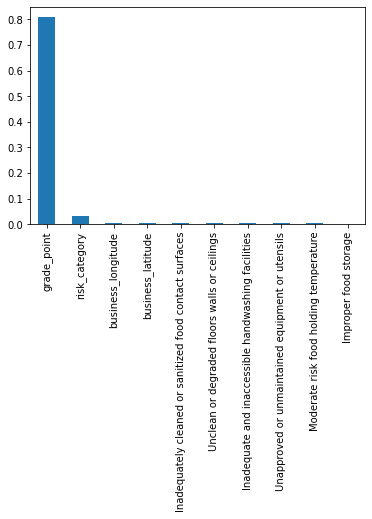

In [39]:
# Feature importance
s = pd.Series(rf.feature_importances_, index=X_train.columns)
s.sort_values(ascending=False)[:10].plot.bar()

In [0]:
# Grid search
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [400, 800], 
    'max_depth': [20, 40, 80],
    'min_samples_split': [4, 8, 16], 
    'min_samples_leaf': [1, 2, 4]
}
# Create a based model
rf = RandomForestRegressor(random_state=RS)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                             cv=3, n_jobs=-1, verbose=2)

In [41]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 33.4min finished


{'max_depth': 20,
 'min_samples_leaf': 4,
 'min_samples_split': 16,
 'n_estimators': 800}

In [42]:
best_rf = grid_search.best_estimator_
print('R^2 train: {}, test: {}'.format(best_rf.score(X_train, y_train), best_rf.score(X_test, y_test)))
# Including lat and long, R^2 train: 0.49793670337357854, test: 0.29549043840108735
# R^2 train: 0.49221660112662335, test: 0.3270729823910128
# H. R^2 train: 0.835238840214809, test: 0.6776040947217664
# {'max_depth': 20,
#  'min_samples_leaf': 4,
#  'min_samples_split': 16,
#  'n_estimators': 800}

R^2 train: 0.835238840214809, test: 0.6776040947217664


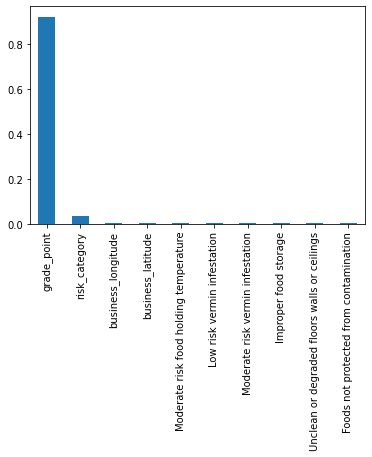

In [43]:
# Feature importance
s = pd.Series(best_rf.feature_importances_, index=X_train.columns)
s.sort_values(ascending=False)[:10].plot.bar()